# Shipment Forecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

In [3]:
pos_data = pd.read_csv('data/pos.csv')
pos_data.head()

,Date,Sales
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


In [4]:
pos_data.isna().sum()

Date     0
Sales    0
dtype: int64

In [5]:
promo_data = pd.read_csv('data/promo.csv', header=None)
promo_data.head()

,0,1
0,2011-11-01,BlackFriday
1,2012-11-01,BlackFriday
2,2013-11-01,BlackFriday


In [6]:
shipment_data = pd.read_csv('data/shipment.csv')
shipment_data.head()

,Date,Shipments
0,2011-01-01,100
1,2011-02-01,319
2,2011-03-01,247
3,2011-04-01,238
4,2011-05-01,214


In [7]:
shipment_data.isna().sum()

Date         0
Shipments    0
dtype: int64

In [8]:
pos_data.Date = pd.to_datetime(pos_data.Date)

promo_data.rename({0:'Date', 1:'BlackFriday'}, axis=1, inplace=True)
promo_data.Date = pd.to_datetime(promo_data.Date)

shipment_data.Date = pd.to_datetime(shipment_data.Date)

In [9]:
pos_data = pos_data.set_index('Date')
promo_data = promo_data.set_index('Date')
shipment_data = shipment_data.set_index('Date')

In [10]:
data = pd.concat([pos_data, promo_data, shipment_data], axis=1)
data.BlackFriday = data.BlackFriday.replace("BlackFriday", 1)
data = data.fillna(0)
data

,Sales,BlackFriday,Shipments
Date,,,
2011-01-01,266.0,0.0,100
2011-02-01,145.9,0.0,319
2011-03-01,183.1,0.0,247
2011-04-01,119.3,0.0,238
2011-05-01,180.3,0.0,214
2011-06-01,168.5,0.0,188
2011-07-01,231.8,0.0,195
2011-08-01,224.5,0.0,209
2011-09-01,192.8,0.0,241


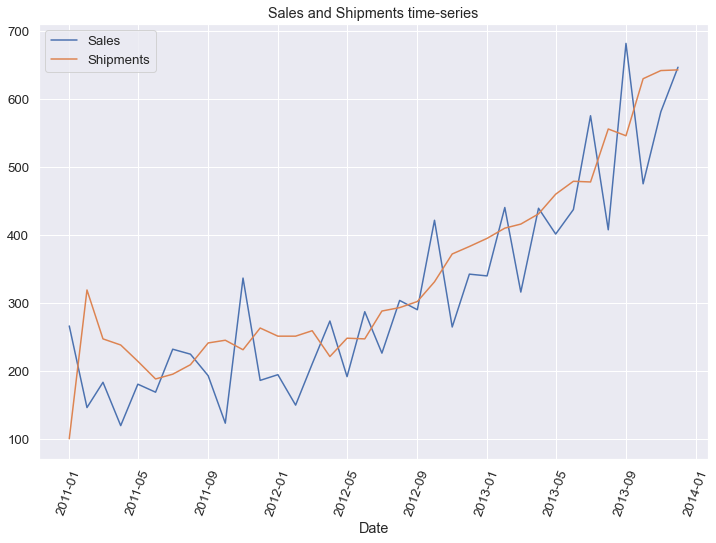

In [11]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.2)

plt.figure(figsize=(12,8))
plt.title('Sales and Shipments time-series')
sns.lineplot(x='Date', y='Sales', data=data, label='Sales')
sns.lineplot(x='Date', y='Shipments', data=data, label='Shipments')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=70);

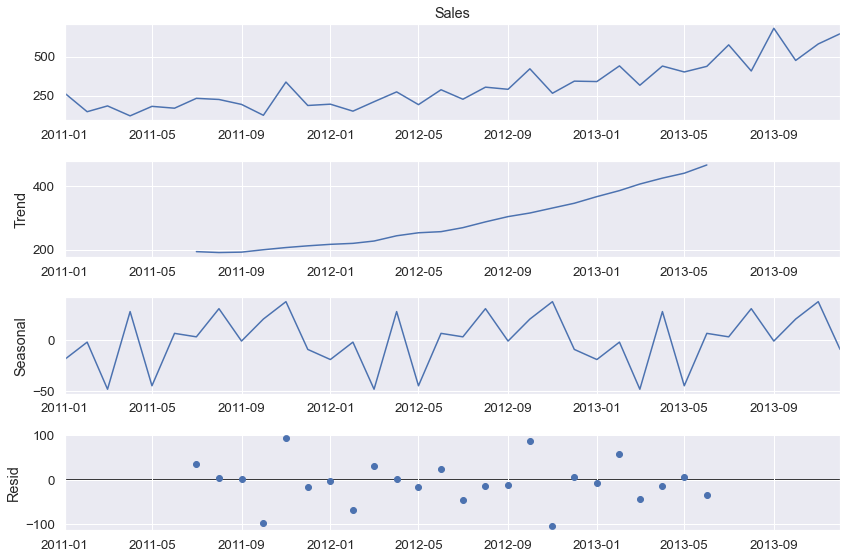

In [13]:
sales_decomp = seasonal_decompose(pos_data.Sales)
sales_decomp.plot()
plt.rcParams.update({'figure.figsize': (12,8)})
plt.show()

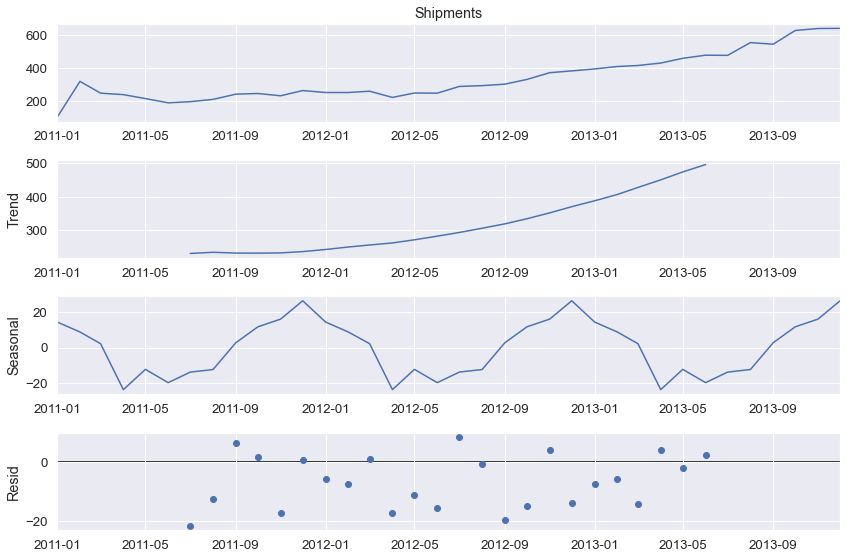

In [14]:
shipment_decomp = seasonal_decompose(shipment_data.Shipments)
shipment_decomp.plot()
plt.rcParams.update({'figure.figsize': (12,8)})
plt.show()

## Moving average

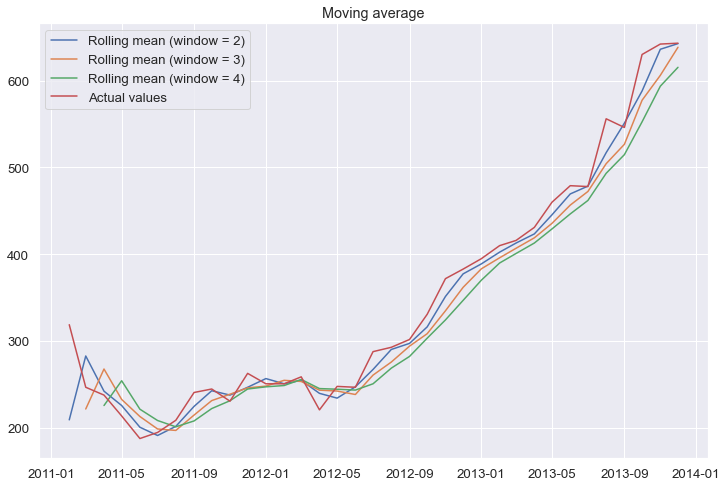

,2,3,4
mae,13.671429,18.313725,24.757576
mape,0.043044,0.055621,0.071015


In [16]:
window_sizes = [2, 3, 4]

mae_errors, mape_errors = [], []

plt.figure(figsize=(12,8))
plt.title('Moving average')

for window in window_sizes:
    rolling_mean = data.Shipments.rolling(window=window).mean()
    plt.plot(rolling_mean, label='Rolling mean (window = {})'.format(window))
    
    mae_errors.append(mae(data.Shipments[(window-1):], rolling_mean[(window-1):]))
    mape_errors.append(mape(data.Shipments[(window-1):], rolling_mean[(window-1):]))

plt.plot(data.Shipments[1:], label='Actual values')
plt.legend(loc='best')
plt.show()

df_metrics = pd.DataFrame({'mae':mae_errors, 
                           'mape':mape_errors
                          }).T
df_metrics.columns = window_sizes
display(df_metrics)

## Exponential Smoothing

### Simple exponential smoothing

In [17]:
alphas = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
values = data.Shipments.values

tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 

predicted_values = {}
for alpha in alphas:
    mae_errors, mape_errors = [], []
    true_values, predicted_values_each_alpha = [], []
    
    for train, test in tscv.split(values):
        model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha)
        predictions = model.forecast(len(test))
        
        actual = values[test]
        true_values.append(actual)
        predicted_values_each_alpha.append(predictions)
        
        mae_errors.append(mae(actual, predictions))
        mape_errors.append(mape(actual, predictions))
        
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))
        
    print(f'For alpha = {alpha}:\nmae = {mae_errors}\nmape = {mape_errors}\n')
    
    predicted_values[alpha] = predicted_values_each_alpha

For alpha = 0.01:
mae = 296.5356405455094
mape = 0.48995391189952536

For alpha = 0.1:
mae = 215.73947550104495
mape = 0.35679550582172426

For alpha = 0.3:
mae = 122.6267672524154
mape = 0.20299795909007962

For alpha = 0.5:
mae = 93.70503104549358
mape = 0.15554347624733159

For alpha = 0.7:
mae = 78.79250273529202
mape = 0.13128083440345728

For alpha = 0.9:
mae = 69.25954477385685
mape = 0.11590383074762163



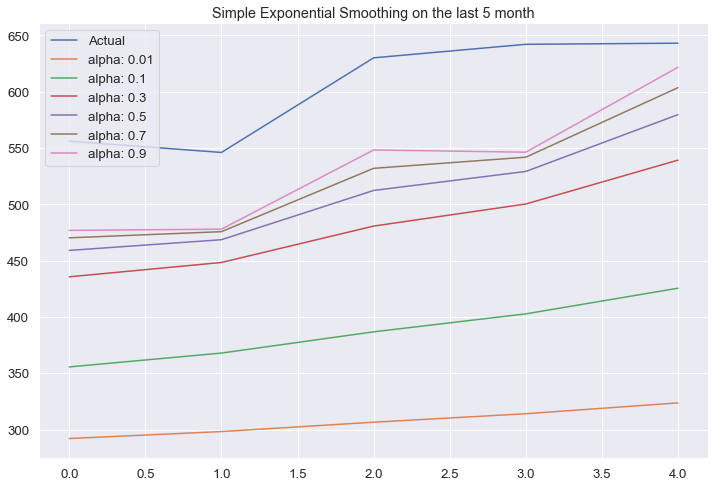

In [18]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')

for alpha in alphas:
    plt.plot(predicted_values[alpha], label=f'alpha: {alpha}')
    
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing on the last 5 month')
plt.show()

### Double exponential smoothing

In [19]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]

values = data.Shipments.values
tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 
predicted_values = {}

for alpha in alphas:
    for beta in betas:
        mae_errors, mape_errors = [], []
        predicted_values_per_params = []
        
        for train, test in tscv.split(values):
            model = ExponentialSmoothing(values[train], trend='additive').fit(smoothing_level=alpha, smoothing_trend=beta)
            predictions = model.forecast(len(test))
        
            actual = values[test]
            predicted_values_per_params.append(predictions)
            
            mae_errors.append(mae(actual, predictions))
            mape_errors.append(mape(actual, predictions))
        
        mae_errors = np.mean(np.array(mae_errors))
        mape_errors = np.mean(np.array(mape_errors))
        
        print(f'For alpha = {alpha}, beta = {beta}:\nmae = {mae_errors}\nmape = {mape_errors}\n')
        
        predicted_values[(alpha, beta)] = predicted_values_per_params

For alpha = 0.1, beta = 0.1:
mae = 132.32918983898014
mape = 0.2186579524374183

For alpha = 0.1, beta = 0.9:
mae = 45.13987174065612
mape = 0.07336673039348446

For alpha = 0.9, beta = 0.1:
mae = 51.32979160945155
mape = 0.08622947788222553

For alpha = 0.9, beta = 0.9:
mae = 52.34605344569959
mape = 0.08770306410742582



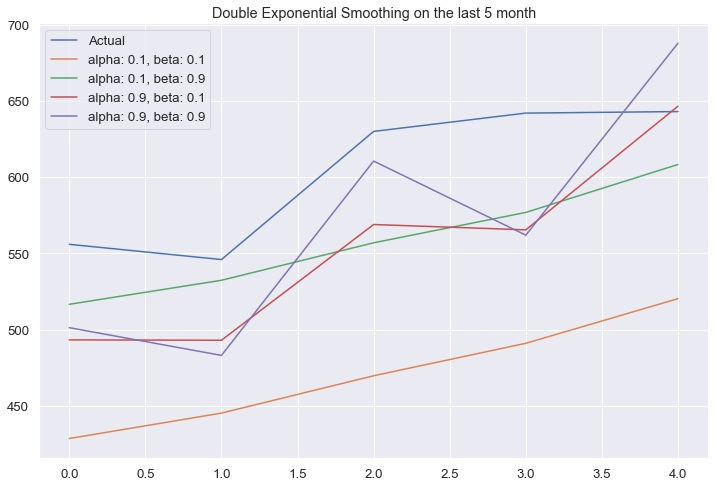

In [20]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')

for alpha in alphas:
    for beta in betas:
        plt.plot(predicted_values[(alpha, beta)], label=f'alpha: {alpha}, beta: {beta}')
    
plt.legend(loc='best')
plt.title('Double Exponential Smoothing on the last 5 month')
plt.show()

### Triple exponential smoothing

In [21]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]
gammas = [0.1, 0.9]

values = data.Shipments.values
tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 
predicted_values = {}

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            mae_errors, mape_errors = [], []
            predicted_values_per_params = []
        
            for train, test in tscv.split(values):
                model = ExponentialSmoothing(values[train], trend='additive', 
                                             seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
                predictions = model.forecast(len(test))
        
                actual = values[test]
                predicted_values_per_params.append(predictions)
            
                mae_errors.append(mae(actual, predictions))
                mape_errors.append(mape(actual, predictions))
        
            mae_errors = np.mean(np.array(mae_errors))
            mape_errors = np.mean(np.array(mape_errors))
        
            print(f'For alpha = {alpha}, beta = {beta}:, gamma = {gamma}\nmae = {mae_errors}\nmape = {mape_errors}\n')
        
            predicted_values[(alpha, beta, gamma)] = predicted_values_per_params

For alpha = 0.1, beta = 0.1:, gamma = 0.1
mae = 147.89132493823598
mape = 0.2454825395671271

For alpha = 0.1, beta = 0.1:, gamma = 0.9
mae = 106.16022448496764
mape = 0.1764021370591225

For alpha = 0.1, beta = 0.9:, gamma = 0.1
mae = 39.476638238656946
mape = 0.06585179313537733

For alpha = 0.1, beta = 0.9:, gamma = 0.9
mae = 39.354091907922474
mape = 0.06461052210593685

For alpha = 0.9, beta = 0.1:, gamma = 0.1
mae = 45.97601210510908
mape = 0.07736564720852425

For alpha = 0.9, beta = 0.1:, gamma = 0.9
mae = 50.205966536286816
mape = 0.08502081417272597

For alpha = 0.9, beta = 0.9:, gamma = 0.1
mae = 41.714945788659236
mape = 0.06942858236898955

For alpha = 0.9, beta = 0.9:, gamma = 0.9
mae = 37.76311181617295
mape = 0.06327833412110137



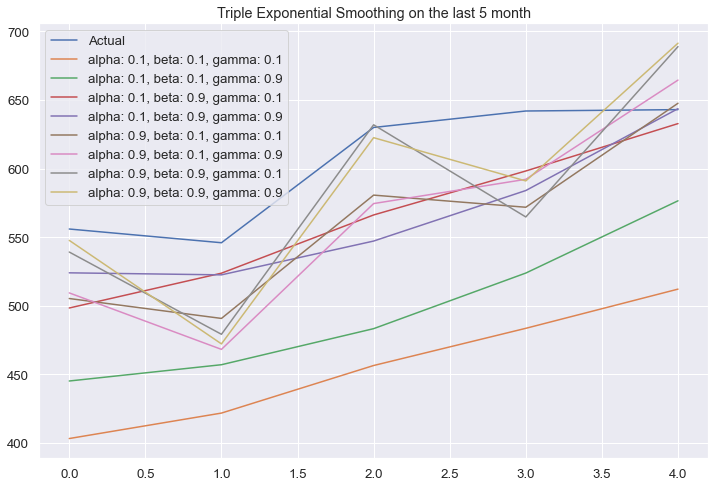

In [22]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            plt.plot(predicted_values[(alpha, beta, gamma)], label=f'alpha: {alpha}, beta: {beta}, gamma: {gamma}')
    
plt.legend(loc='best')
plt.title('Triple Exponential Smoothing on the last 5 month')
plt.show()

### Linear regression using Lag features

In [23]:
data_lag = data.copy()
periods = 1
data_lag['Lag_sales'] = data_lag['Sales'].shift(periods=periods)
data_lag['Lag_shipments'] = data_lag['Shipments'].shift(periods=periods)
data_lag.dropna(inplace=True)

X, y = data_lag[['Lag_sales', 'BlackFriday', 'Lag_shipments']], data_lag[['Shipments']]

In [24]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

mae_errors, mape_errors = [], []
predicted_values = []
for train, test in tscv.split(X):
    model = LinearRegression()
    model.fit(X.values[train], y.values[train])
    prediction = model.predict(X.values[test])
    
    predicted_values.append(prediction[0])
    actual = values[test]
    
    
    mae_errors.append(mae(y.values[test], prediction))
    mape_errors.append(mape(y.values[test], prediction))
    
mae_errors = np.mean(np.array(mae_errors))
mape_errors = np.mean(np.array(mape_errors))

print(f'mae = {mae_errors}\nmape = {mape_errors}\n')

mae = 25.015626018622207
mape = 0.041700644712489965



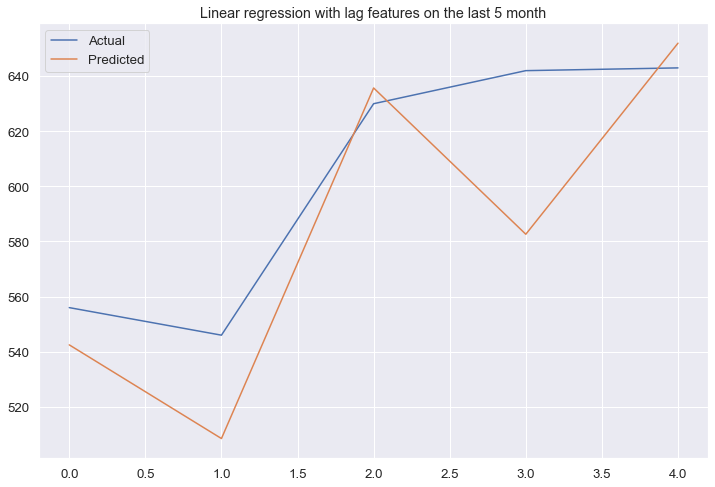

In [25]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.legend(loc='best')
plt.title('Linear regression with lag features on the last 5 month')
plt.show()

## Phrophet

In [26]:
data_prophet = data.copy()

In [27]:
data_prophet.reset_index(inplace=True)
data_prophet = data_prophet.rename(columns = {'Date': 'ds',
                                              'Shipments': 'y'})
data_prophet = data_prophet.loc[:, ['ds', 'y']]

### Initial prophet

In [28]:
def validate_prophet(holidays=None):
    values = data_prophet.values
    tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(values):
        df_train = pd.DataFrame(values[train]).rename(columns = {0: 'ds', 1: 'y'})
        model = Prophet(holidays=holidays)
        model.fit(df_train)
    
        future_date = pd.DataFrame(data_prophet.iloc[test[0]]).T[['ds']]
        prediction = model.predict(future_date)
        predicted_values.append(prediction.yhat)
    
        mae_errors.append(mae(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
        mape_errors.append(mape(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mae = {mae_errors}\nmape = {mape_errors}\n')

In [29]:
validate_prophet()


Initial log joint probability = -46.5606
Iteration  1. Log joint probability =    28.3813. Improved by 74.9418.
Iteration  2. Log joint probability =    43.2674. Improved by 14.8862.
Iteration  3. Log joint probability =    49.9235. Improved by 6.65611.
Iteration  4. Log joint probability =    55.5987. Improved by 5.6752.
Iteration  5. Log joint probability =    60.1062. Improved by 4.5075.
Iteration  6. Log joint probability =    60.1337. Improved by 0.027481.
Iteration  7. Log joint probability =     60.184. Improved by 0.050355.
Iteration  8. Log joint probability =    60.2617. Improved by 0.0776683.
Iteration  9. Log joint probability =    60.3526. Improved by 0.0908426.
Iteration 10. Log joint probability =    60.3777. Improved by 0.0251072.
Iteration 11. Log joint probability =    60.4085. Improved by 0.0308403.
Iteration 12. Log joint probability =    60.4239. Improved by 0.0153591.
Iteration 13. Log joint probability =    60.4315. Improved by 0.00766746.
Iteration 14. Log join

### Phrophet with holidays

In [30]:
black_friday = promo_data.reset_index()
black_friday.columns = ['ds', 'holiday']

validate_prophet(holidays=black_friday)


Initial log joint probability = -49.7821
Iteration  1. Log joint probability =    28.3813. Improved by 78.1634.
Iteration  2. Log joint probability =    43.2969. Improved by 14.9156.
Iteration  3. Log joint probability =    49.7591. Improved by 6.46225.
Iteration  4. Log joint probability =    55.2151. Improved by 5.45598.
Iteration  5. Log joint probability =    60.1216. Improved by 4.90646.
Iteration  6. Log joint probability =    60.1499. Improved by 0.0282926.
Iteration  7. Log joint probability =    60.2006. Improved by 0.0506869.
Iteration  8. Log joint probability =    60.2774. Improved by 0.0768801.
Iteration  9. Log joint probability =     60.364. Improved by 0.0865796.
Iteration 10. Log joint probability =    60.4083. Improved by 0.0442961.
Iteration 11. Log joint probability =    60.4393. Improved by 0.0309582.
Iteration 12. Log joint probability =    60.4546. Improved by 0.0153449.
Iteration 13. Log joint probability =    60.6413. Improved by 0.186664.
Iteration 14. Log jo

### Make next month prediction with Linear regression model

In [31]:
final_model = LinearRegression()
final_model.fit(X.values, y.values)
future_x = np.array([data.iloc[-periods].values])
prediction = final_model.predict(future_x)
float(prediction)

678.7811435050317